In [13]:
!pip install einops

Defaulting to user installation because normal site-packages is not writeable


In [14]:
!pip install torch torchvision torchaudio
!pip install einops
!pip install pandas
!pip install matplotlib
!pip install tqdm


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.amp import autocast, GradScaler
from contextlib import nullcontext
from typing import Optional

In [16]:
class StandardAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = F.softmax(dots, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [17]:
class FlashAttention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0., max_seq_length=1024):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.dropout = dropout
        self.max_seq_length = max_seq_length

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

        # Create causal mask for attention
        self.register_buffer(
            "causal_mask",
            torch.triu(
                torch.ones(max_seq_length, max_seq_length, dtype=torch.bool),
                diagonal=1
            ).view(1, 1, max_seq_length, max_seq_length)
        )

    def forward(self, x, mask: Optional[torch.Tensor] = None):
        b, n, d = x.shape
        h = self.heads

        # Split heads and scale queries
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        # Scale queries
        q = q * self.scale

        # Try using torch's optimized attention first
        try:
            # Set attention mask
            if mask is not None:
                mask = mask.view(b, 1, 1, n)
                mask = mask.expand(-1, h, -1, -1)

            # Use PyTorch's memory-efficient attention implementation
            with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=True):
                if x.dtype == torch.float32:
                    # Convert to float16 for flash attention
                    with torch.autocast(device_type='cuda', dtype=torch.float16):
                        attn_output = F.scaled_dot_product_attention(
                            q.half(), k.half(), v.half(),
                            attn_mask=mask,
                            dropout_p=self.dropout if self.training else 0.0,
                            is_causal=False
                        )
                    attn_output = attn_output.float()
                else:
                    attn_output = F.scaled_dot_product_attention(
                        q, k, v,
                        attn_mask=mask,
                        dropout_p=self.dropout if self.training else 0.0,
                        is_causal=False
                    )

        except (RuntimeError, NotImplementedError) as e:
            # Fall back to chunked attention if flash attention is not available
            chunk_size = 128  # Adjust based on GPU memory
            chunks = n // chunk_size + (1 if n % chunk_size != 0 else 0)

            attn_outputs = []
            for i in range(chunks):
                start_idx = i * chunk_size
                end_idx = min(start_idx + chunk_size, n)

                # Calculate attention for current chunk
                chunk_q = q[:, :, start_idx:end_idx]

                # Compute attention scores
                dots = torch.matmul(chunk_q, k.transpose(-1, -2))

                # Apply mask if provided
                if mask is not None:
                    chunk_mask = mask[:, :, start_idx:end_idx]
                    dots = dots.masked_fill(~chunk_mask, float('-inf'))

                # Apply softmax and dropout
                attn = F.softmax(dots, dim=-1)
                if self.training:
                    attn = F.dropout(attn, p=self.dropout)

                # Compute chunk output
                chunk_output = torch.matmul(attn, v)
                attn_outputs.append(chunk_output)

            # Concatenate chunks
            attn_output = torch.cat(attn_outputs, dim=2)

        # Merge heads and project
        out = rearrange(attn_output, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [18]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [19]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [20]:
class ViTVariant(nn.Module):
    def __init__(
        self,
        *,
        image_size=224,
        patch_size=16,
        num_classes=100,
        dim=768,
        depth=12,
        heads=12,
        mlp_dim=3072,
        channels=3,
        dim_head=64,
        dropout=0.1,
        emb_dropout=0.1,
        use_flash_attention=True
    ):
        super().__init__()
        assert image_size % patch_size == 0, 'Image size must be divisible by patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size * patch_size

        self.patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_dim, dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        # Choose attention mechanism based on parameter
        attention_layer = FlashAttention if use_flash_attention else StandardAttention

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, attention_layer(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        x = x[:, 0]
        return self.mlp_head(x)

In [21]:
class ComparativeBenchmark:
    def __init__(self, batch_sizes=[1, 4, 8, 16, 32],
                 image_size=224, num_warmup=10, num_iterations=100):
        self.batch_sizes = batch_sizes
        self.image_size = image_size
        self.num_warmup = num_warmup
        self.num_iterations = num_iterations
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create both model variants
        self.flash_model = ViTVariant(use_flash_attention=True).to(self.device)
        self.standard_model = ViTVariant(use_flash_attention=False).to(self.device)

    def generate_dummy_data(self, batch_size):
        images = torch.randn(batch_size, 3, self.image_size, self.image_size)
        labels = torch.randint(0, 100, (batch_size,))
        return images, labels

    def benchmark_model(self, model, batch_size, mode='train', use_amp=True):
        model.train() if mode == 'train' else model.eval()
        scaler = GradScaler('cuda') if use_amp and mode == 'train' else None
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-4) if mode == 'train' else None

        # Warmup
        for _ in range(self.num_warmup):
            images, labels = self.generate_dummy_data(batch_size)
            images, labels = images.to(self.device), labels.to(self.device)

            with torch.no_grad() if mode != 'train' else nullcontext():
                with autocast(device_type='cuda') if use_amp else nullcontext():
                    outputs = model(images)
                    if mode == 'train':
                        loss = criterion(outputs, labels)
                        if use_amp:
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            loss.backward()
                            optimizer.step()
                        optimizer.zero_grad()

        # Benchmark
        torch.cuda.synchronize()
        start_time = time.perf_counter()

        for _ in range(self.num_iterations):
            images, labels = self.generate_dummy_data(batch_size)
            images, labels = images.to(self.device), labels.to(self.device)

            with torch.no_grad() if mode != 'train' else nullcontext():
                with autocast(device_type='cuda') if use_amp else nullcontext():
                    outputs = model(images)
                    if mode == 'train':
                        loss = criterion(outputs, labels)
                        if use_amp:
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            loss.backward()
                            optimizer.step()
                        optimizer.zero_grad()

        torch.cuda.synchronize()
        end_time = time.perf_counter()

        avg_time = (end_time - start_time) / self.num_iterations
        return avg_time * 1000  # Convert to milliseconds

    def run_comparative_benchmark(self):
        results = []

        for batch_size in self.batch_sizes:
            print(f"\nBenchmarking batch size: {batch_size}")

            # Training benchmarks
            flash_train_time = self.benchmark_model(self.flash_model, batch_size, mode='train')
            standard_train_time = self.benchmark_model(self.standard_model, batch_size, mode='train')

            # Inference benchmarks
            flash_infer_time = self.benchmark_model(self.flash_model, batch_size, mode='inference')
            standard_infer_time = self.benchmark_model(self.standard_model, batch_size, mode='inference')

            results.append({
                'batch_size': batch_size,
                'flash_train_ms': flash_train_time,
                'standard_train_ms': standard_train_time,
                'flash_infer_ms': flash_infer_time,
                'standard_infer_ms': standard_infer_time,
                'train_speedup': standard_train_time / flash_train_time,
                'infer_speedup': standard_infer_time / flash_infer_time
            })

        return pd.DataFrame(results)

    def plot_results(self, results):
        plt.figure(figsize=(15, 10))

        # Training time comparison
        plt.subplot(2, 2, 1)
        plt.plot(results['batch_size'], results['flash_train_ms'], 'b-o', label='Flash Attention')
        plt.plot(results['batch_size'], results['standard_train_ms'], 'r-o', label='Standard Attention')
        plt.xlabel('Batch Size')
        plt.ylabel('Training Time (ms)')
        plt.title('Training Time Comparison')
        plt.legend()
        plt.grid(True)

        # Inference time comparison
        plt.subplot(2, 2, 2)
        plt.plot(results['batch_size'], results['flash_infer_ms'], 'b-o', label='Flash Attention')
        plt.plot(results['batch_size'], results['standard_infer_ms'], 'r-o', label='Standard Attention')
        plt.xlabel('Batch Size')
        plt.ylabel('Inference Time (ms)')
        plt.title('Inference Time Comparison')
        plt.legend()
        plt.grid(True)

        # Speedup comparison
        plt.subplot(2, 2, 3)
        plt.plot(results['batch_size'], results['train_speedup'], 'g-o', label='Training')
        plt.plot(results['batch_size'], results['infer_speedup'], 'b-o', label='Inference')
        plt.xlabel('Batch Size')
        plt.ylabel('Speedup (×)')
        plt.title('Flash Attention Speedup')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

In [22]:
def run_comparison():
    print("Initializing comparative benchmark...")
    benchmark = ComparativeBenchmark(
        batch_sizes=[16, 32, 64, 128, 256],
        image_size=224,
        num_warmup=5,
        num_iterations=50
    )

    print("Running benchmarks...")
    results = benchmark.run_comparative_benchmark()

    print("\nResults:")
    print(results.to_string(index=False))

    print("\nPlotting results...")
    benchmark.plot_results(results)

    return results

Initializing comparative benchmark...
Running benchmarks...

Benchmarking batch size: 16


/share/apps/pyenv/py3.9/lib/python3.9/contextlib.py:87: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)



Benchmarking batch size: 32

Benchmarking batch size: 64

Benchmarking batch size: 128

Benchmarking batch size: 256

Results:
 batch_size  flash_train_ms  standard_train_ms  flash_infer_ms  standard_infer_ms  train_speedup  infer_speedup
         16       53.038760          57.209185       29.826680          29.917025       1.078630       1.003029
         32       80.881161          94.161342       49.698082          49.633290       1.164194       0.998696
         64      156.295521         183.497359       93.735401          93.849544       1.174041       1.001218
        128      297.264711         353.873496      177.331204         177.867273       1.190432       1.003023
        256      581.151282         689.016176      341.334433         341.536947       1.185606       1.000593

Plotting results...


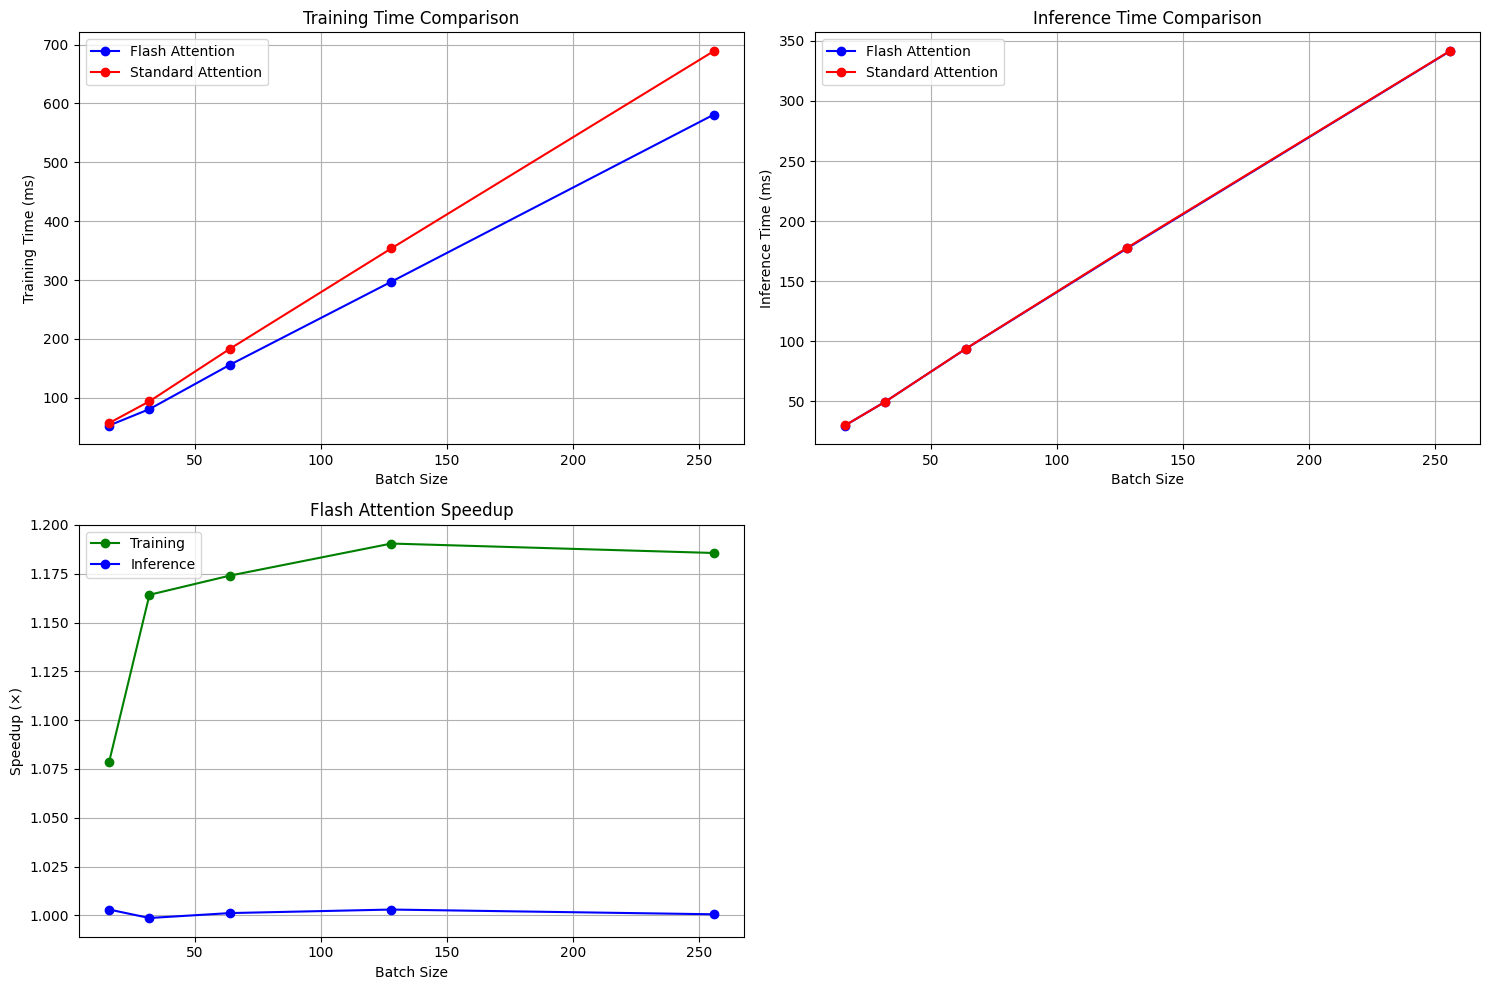

In [23]:
results = run_comparison()